In [85]:
# Parameters and imports for the notebook
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.io.fits.hdu.hdulist import HDUList
from mangadap.util.fileio import channel_dictionary, channel_units
%matplotlib widget

hdu: HDUList = fits.open('dap/HYB10-C3K-MASTARHC2/gnifu-FinalerCube-MAPS-HYB10-C3K-MASTARHC2.fits.gz')
logcube: HDUList = fits.open("dap/HYB10-C3K-MASTARHC2/gnifu-FinalerCube-LOGCUBE-HYB10-C3K-MASTARHC2.fits.gz")
center = [15, 24] # from bottom left

manga_hdu: HDUList = fits.open("manga-8262-9102-MAPS-HYB10-MILESHC-MASTARSSP.fits.gz")
manga_logcube: HDUList = fits.open("manga-8262-9102-LOGCUBE-HYB10-MILESHC-MASTARSSP.fits.gz")
useMangaInstead = False

# Calculate various shapes of the data
manga_center = [manga_hdu[3].data.shape[1] // 2, manga_hdu[3].data.shape[0] // 2]
if useMangaInstead:
    center = manga_center
    hdu = manga_hdu
    logcube = manga_logcube
    print("Using MaNGA data")
# Build dictionaries with the emission-line and spectral-index
# channel names to ease selection and get the spectral-index units
emlc = channel_dictionary(hdu, "EMLINE_GFLUX")  # library of emission lines
spic = channel_dictionary(hdu, "SPECINDEX")
spiu = channel_units(hdu, "SPECINDEX")
snr = np.ma.MaskedArray(hdu["BIN_SNR"].data, mask=hdu["BINID"].data[0] < 0)
manga_emlc = channel_dictionary(manga_hdu, "EMLINE_GFLUX")
manga_spic = channel_dictionary(manga_hdu, "SPECINDEX")
manga_spiu = channel_units(manga_hdu, "SPECINDEX")
manga_snr = np.ma.MaskedArray(manga_hdu["BIN_SNR"].data, mask=manga_hdu["BINID"].data[0] < 0)

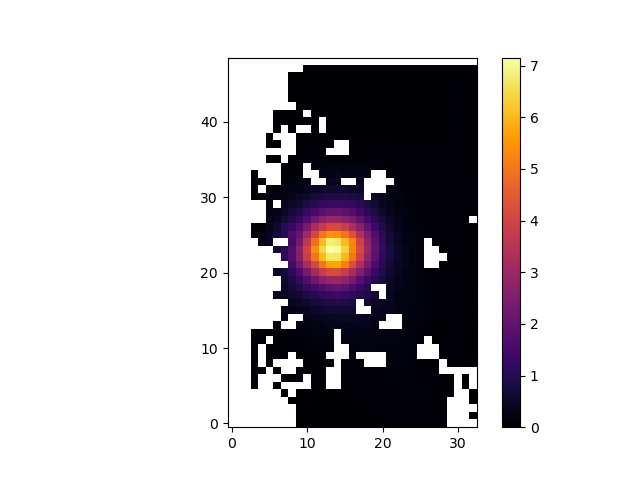

In [87]:
# Ha flux map
mask_ext = hdu["EMLINE_GFLUX"].header["QUALDATA"]
halpha_flux = np.ma.MaskedArray(
    hdu["EMLINE_GFLUX"].data[emlc["Ha-6564"]],
    mask=hdu[mask_ext].data[emlc["Ha-6564"]] > 0,
)
plt.figure()
plt.imshow(halpha_flux, origin="lower", interpolation="nearest", cmap="inferno")
plt.colorbar()
plt.show()

/tmp/ipykernel_57382/1661823238.py:12: RuntimeWarning: divide by zero encountered in true_divide
  hdu["EMLINE_GFLUX"].data[emlc["NII-6585"]]
/tmp/ipykernel_57382/1661823238.py:12: RuntimeWarning: invalid value encountered in true_divide
  hdu["EMLINE_GFLUX"].data[emlc["NII-6585"]]


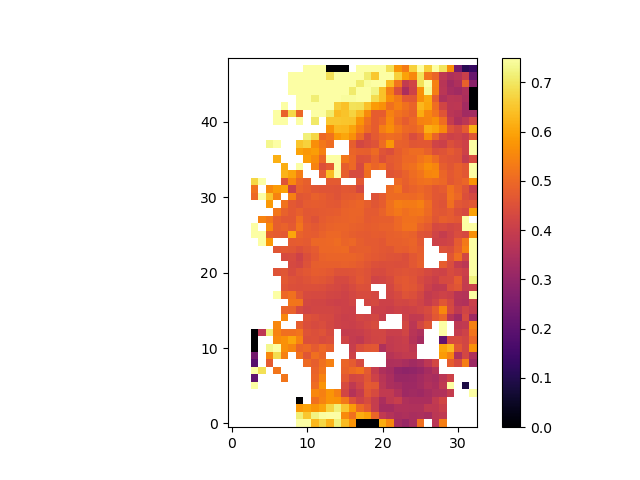

In [88]:
# Nii/Ha flux map
mask_ext = hdu["EMLINE_GFLUX"].header["QUALDATA"]
ivar_extension = hdu["EMLINE_GFLUX"].header["ERRDATA"]
snr_map_ha = hdu["EMLINE_GFLUX"].data[emlc["Ha-6564"]] * np.sqrt(
    hdu[ivar_extension].data[emlc["Ha-6564"]]
)
snr_map_nii = hdu["EMLINE_GFLUX"].data[emlc["NII-6585"]] * np.sqrt(
    hdu[ivar_extension].data[emlc["NII-6585"]]
)
sncut = 3
nii_flux = np.ma.MaskedArray(
    hdu["EMLINE_GFLUX"].data[emlc["NII-6585"]]
    / hdu["EMLINE_GFLUX"].data[emlc["Ha-6564"]],
    mask=hdu[mask_ext].data[emlc["NII-6585"]] > 0 | (snr_map_nii[:, :] < sncut),
)
plt.figure()
plt.imshow(nii_flux, origin="lower", interpolation="nearest", cmap="inferno", vmax=0.75)
plt.colorbar()
plt.show()

/tmp/ipykernel_57382/3422126507.py:5: RuntimeWarning: divide by zero encountered in reciprocal
  snr_map = flux / (hdu[ivar_extension].data[emlc[line]] ** -1)
/tmp/ipykernel_57382/3422126507.py:20: RuntimeWarning: divide by zero encountered in log10
  log_nii_ha = np.log10(nii_flux / halpha_flux)
/tmp/ipykernel_57382/3422126507.py:20: RuntimeWarning: invalid value encountered in log10
  log_nii_ha = np.log10(nii_flux / halpha_flux)
/tmp/ipykernel_57382/3422126507.py:30: RuntimeWarning: divide by zero encountered in log10
  manga_log_nii_ha = np.log10(manga_nii_flux / manga_ha_flux)


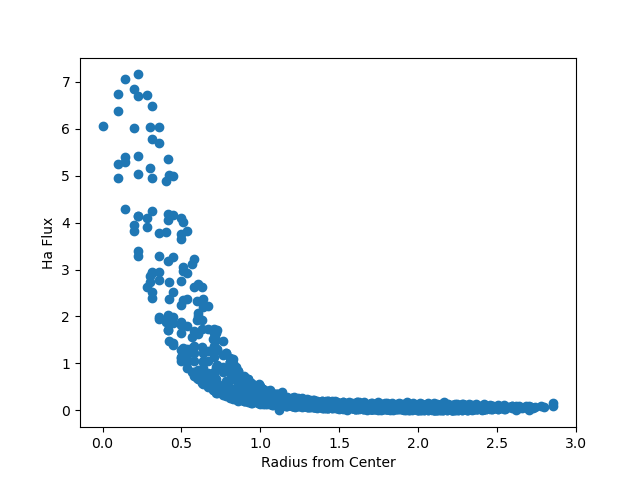

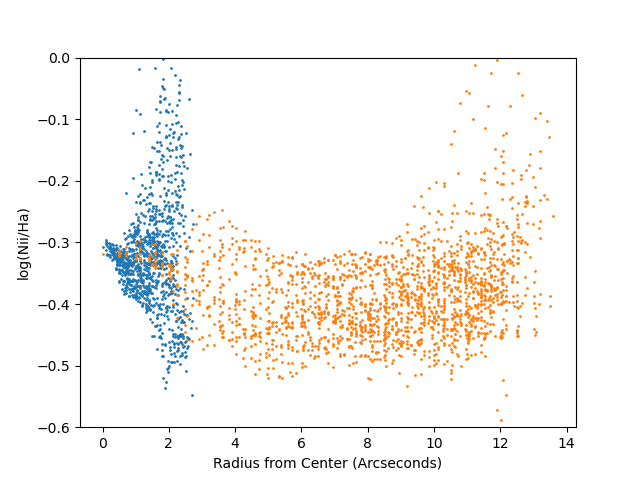

In [106]:
# log(Nii/Ha) vs. radius from center
sncut = 10
def flux(line, hdu, emlc, mask_ext):
    flux = hdu["EMLINE_GFLUX"].data[emlc[line]]
    snr_map = flux / (hdu[ivar_extension].data[emlc[line]] ** -1)
    snr_map_nii = hdu["EMLINE_GFLUX"].data[emlc["NII-6585"]] * np.sqrt(
        hdu[ivar_extension].data[emlc["NII-6585"]]
    )
    return np.ma.MaskedArray(
        flux,
        mask=hdu[mask_ext].data[emlc[line]] > 3 | (snr_map_nii[:, :] < sncut),
    )


def get_distance(x, y, center, arcsecs_per_pixel=0.1):
    return ((x - center[0]) ** 2 + (y - center[1]) ** 2) ** 0.5 * arcsecs_per_pixel

halpha_flux = flux("Ha-6564", hdu, emlc, mask_ext)
nii_flux = flux("NII-6585", hdu, emlc, mask_ext)
log_nii_ha = np.log10(nii_flux / halpha_flux)
radius = get_distance(
    np.arange(halpha_flux.shape[1]),
    np.arange(halpha_flux.shape[0])[:, None],
    center,
    0.1,
)

manga_ha_flux = flux("Ha-6564", manga_hdu, manga_emlc, mask_ext)
manga_nii_flux = flux("NII-6585", manga_hdu, manga_emlc, mask_ext)
manga_log_nii_ha = np.log10(manga_nii_flux / manga_ha_flux)
manga_radius = get_distance(
    np.arange(manga_ha_flux.shape[1]),
    np.arange(manga_ha_flux.shape[0])[:, None],
    manga_center,
    0.5,
)
# plt.figure() # Make sure radius array looks right
# plt.imshow(manga_radius, origin="lower", interpolation="nearest", cmap="inferno")
plt.figure()
plt.scatter(radius, log_nii_ha, s=1)
plt.scatter(manga_radius, manga_log_nii_ha, s=1)
plt.ylim(-0.6, 0)
plt.xlabel("Radius from Center (Arcseconds)")
plt.ylabel("log(Nii/Ha)")
plt.figure()
plt.scatter(radius, halpha_flux)
plt.xlabel("Radius from Center")
plt.ylabel("Ha Flux")
plt.show()

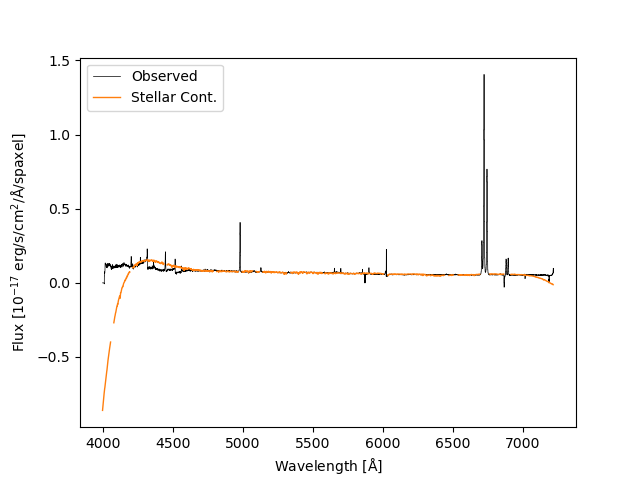

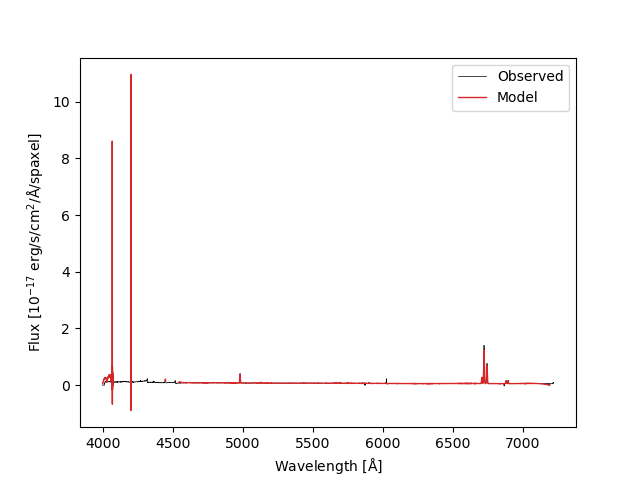

In [ ]:
# Check fit against data
j,i = np.unravel_index(snr.argmax(), snr.shape) # Bin with highest SNR
# j = max(j - 1, 0)
# i = max(i - 4, 0)
# NOTE: the wavelength vectors for the DAP and DRP LOGCUBE files should be identical
wave = logcube['WAVE'].data
flux = np.ma.MaskedArray(logcube['FLUX'].data[:,j,i], mask=logcube['MASK'].data[:,j,i] > 0)
model = np.ma.MaskedArray(logcube['MODEL'].data[:,j,i],
                          mask=logcube['MODEL_MASK'].data[:,j,i]>0)
plt.figure()
plt.step(wave, flux, where='mid', color='k', lw=0.5, label='Observed')
plt.plot(wave, model, color='C3', lw=1, label='Model')
plt.xlabel(r'Wavelength [${\rm \AA}$]')
plt.ylabel(r'Flux [$10^{-17}$ erg/s/cm$^2$/${\rm \AA}$/spaxel]')
plt.legend()

binned_flux = np.ma.MaskedArray(logcube['FLUX'].data[:,j,i],
                                mask=logcube['MASK'].data[:,j,i] > 0)
stellarcontinuum = np.ma.MaskedArray(logcube['STELLAR'].data[:,j,i],
                                     mask=logcube['STELLAR_MASK'].data[:,j,i] > 0)
plt.figure()
plt.step(wave, binned_flux, where='mid', color='k', lw=0.5, label='Observed')
plt.plot(wave, stellarcontinuum, color='C1', lw=1,label='Stellar Cont.')
plt.xlabel(r'Wavelength [${\rm \AA}$]')
plt.ylabel(r'Flux [$10^{-17}$ erg/s/cm$^2$/${\rm \AA}$/spaxel]')
plt.legend()
plt.show() 